In [1]:
# Configuration OpenMP
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Imports des modules locaux
from data_loading import *
from models import *
from training import *
from visualization import *
from evaluation import *

# Import explicite des nouvelles fonctions (pour s'assurer qu'elles sont disponibles)
from evaluation import generate_model_predictions, evaluate_model_on_sample, display_evaluation_results


print("✓ Modules rechargés avec succès")

✓ Modules rechargés avec succès


### Env configuration

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# Data path configuration
project_root = Path(os.getcwd()).parent.parent  # go back from modular -> NFTM_for_Physic -> NFTM
data_dir = project_root / "Data"
print(f"Data directory: {data_dir}")

# Check file existence
files_burger = {
    0.001: data_dir / "burgers1D_training_data_Nu0.001.npz",
    0.01:  data_dir / "burgers1D_training_data_Nu0.01.npz",
    0.1:   data_dir / "burgers1D_training_data_Nu0.1.npz",
    0.5:   data_dir / "burgers1D_training_data_Nu0.5.npz",
}

print("\nAvailable data files:")
for nu, filepath in files_burger.items():
    exists = "✓" if filepath.exists() else "✗"
    print(f"  {exists} Nu={nu}: {filepath.name}")

Device used: cuda
Data directory: c:\Dev\CentralSupelec\BDRP\NFTM\Data

Available data files:
  ✓ Nu=0.001: burgers1D_training_data_Nu0.001.npz
  ✓ Nu=0.01: burgers1D_training_data_Nu0.01.npz
  ✓ Nu=0.1: burgers1D_training_data_Nu0.1.npz
  ✓ Nu=0.5: burgers1D_training_data_Nu0.5.npz


### Load the data

In [3]:
# Create dataloader
batch_size = 4
train_loader = create_simple_dataloader(files_burger, batch_size=batch_size)

print(f"DataLoader created with batch_size={batch_size}")
print(f"Number of batches: {len(train_loader)}")

# Inspect a sample
init_field, true_traj, nu = next(iter(train_loader))
print(f"\nData shapes:")
print(f"  - init_field: {init_field.shape}")
print(f"  - true_traj: {true_traj.shape}")
print(f"  - nu values: {nu}")

DataLoader created with batch_size=4
Number of batches: 1

Data shapes:
  - init_field: torch.Size([4, 1024])
  - true_traj: torch.Size([4, 201, 1024])
  - nu values: tensor([[0.0010],
        [0.5000],
        [0.0100],
        [0.1000]])


### Load model

In [4]:
# Model configuration
patch_radius = 1
patch_size = 2 * patch_radius + 1

# model = CNNControllerPatch(patch_size=patch_size)
# model = model.to(device)

# model = RNNControllerPatch(patch_size=patch_size)
# model = model.to(device)

patch_radius = 1
patch_size = 2 * patch_radius + 1
chunk_size = 3

model = CNNControllerHistory(patch_size=patch_size, hidden_size=64)


print(f"CNN model created:")
print(f"  - Patch radius: {patch_radius}")
print(f"  - Patch size: {patch_size}")
print(f"  - Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

CNN model created:
  - Patch radius: 1
  - Patch size: 3
  - Number of parameters: 8770

Model architecture:
CNNControllerHistory(
  (embed): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (attn): Linear(in_features=64, out_features=1, bias=True)
  (fc_out): Sequential(
    (0): ReLU()
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Model training

In [13]:
num_epochs = 10

print(f"Starting training for {num_epochs} epochs...")
print("=" * 50)

# train_losses = train_cnn_patch(
#     model,
#     dataloader=train_loader,
#     device=device,
#     num_epochs=num_epochs,
#     patch_radius=patch_radius,
# )

# train_losses = train_rnn_patch(
#     model,
#     dataloader=train_loader,
#     device=device,
#     num_epochs=num_epochs,
#     patch_radius=patch_radius,
# )

train_losses = train_rnn_patch(
    model=model,
    dataloader=train_loader,
    device=device,
    chunk_size=chunk_size,
    num_epochs=30,
    patch_radius=patch_radius,
)

print("\nTraining completed!")

Starting training for 10 epochs...
[RNN] Epoch 1/30 - MSE: 1.566721e-02
[RNN] Epoch 2/30 - MSE: 1.026904e-02
[RNN] Epoch 3/30 - MSE: 7.762467e-03
[RNN] Epoch 4/30 - MSE: 7.366222e-03
[RNN] Epoch 5/30 - MSE: 7.861559e-03
[RNN] Epoch 6/30 - MSE: 8.284232e-03
[RNN] Epoch 7/30 - MSE: 8.242706e-03
[RNN] Epoch 8/30 - MSE: 7.630046e-03
[RNN] Epoch 9/30 - MSE: 6.738429e-03
[RNN] Epoch 10/30 - MSE: 5.835927e-03
[RNN] Epoch 11/30 - MSE: 5.141950e-03
[RNN] Epoch 12/30 - MSE: 4.835856e-03
[RNN] Epoch 13/30 - MSE: 4.850550e-03
[RNN] Epoch 14/30 - MSE: 5.003901e-03
[RNN] Epoch 15/30 - MSE: 5.090876e-03
[RNN] Epoch 16/30 - MSE: 4.976841e-03
[RNN] Epoch 17/30 - MSE: 4.749512e-03
[RNN] Epoch 18/30 - MSE: 4.436026e-03
[RNN] Epoch 19/30 - MSE: 4.192696e-03
[RNN] Epoch 20/30 - MSE: 4.105526e-03
[RNN] Epoch 21/30 - MSE: 4.122932e-03
[RNN] Epoch 22/30 - MSE: 4.181616e-03
[RNN] Epoch 23/30 - MSE: 4.137775e-03
[RNN] Epoch 24/30 - MSE: 3.980299e-03
[RNN] Epoch 25/30 - MSE: 3.816602e-03
[RNN] Epoch 26/30 - MSE:

### Loss funciton

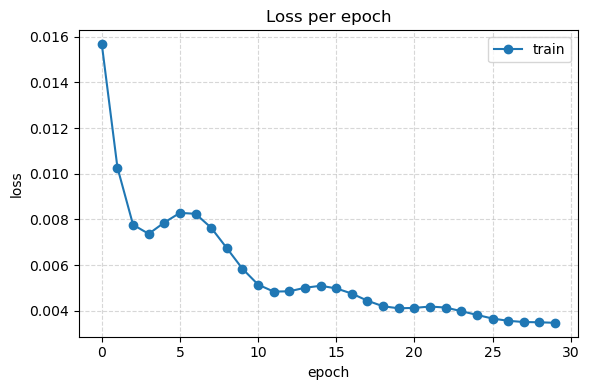

Final loss: 0.003470
Loss reduction: 77.85%


In [14]:
plot_losses(train_losses)

print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1])/train_losses[0]*100):.2f}%")

### Generate prediction

In [ ]:
# Generate predictions with dedicated function
true_traj, pred_traj, nu_value = generate_model_predictions(
    model,
    train_loader,
    device,
    patch_radius,
    verbose=True,
    chunk_size=3,  # ou autre
)

Generating predictions for nu = 0.5000
True trajectory shape: torch.Size([201, 1024])
Model type: CNNControllerHistory
CNN mode: Generating 200 time steps...
  Pas 0/200


ValueError: not enough values to unpack (expected 3, got 2)

### Visualization

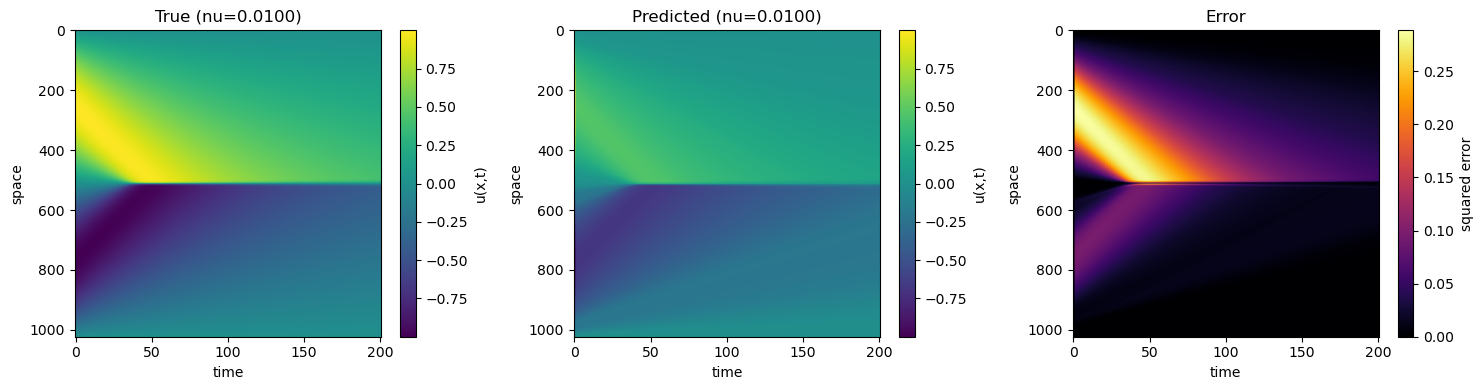

In [ ]:
# Visualize trajectories
plot_trajectories(true_traj, pred_traj, title_suffix=f" (nu={nu_value:.4f})")

### Evaluation

Métriques d'évaluation:
  - PSNR: 13.276 dB
  - SSIM: 0.783
  - MSE: 0.047029
  - R²: 0.8045


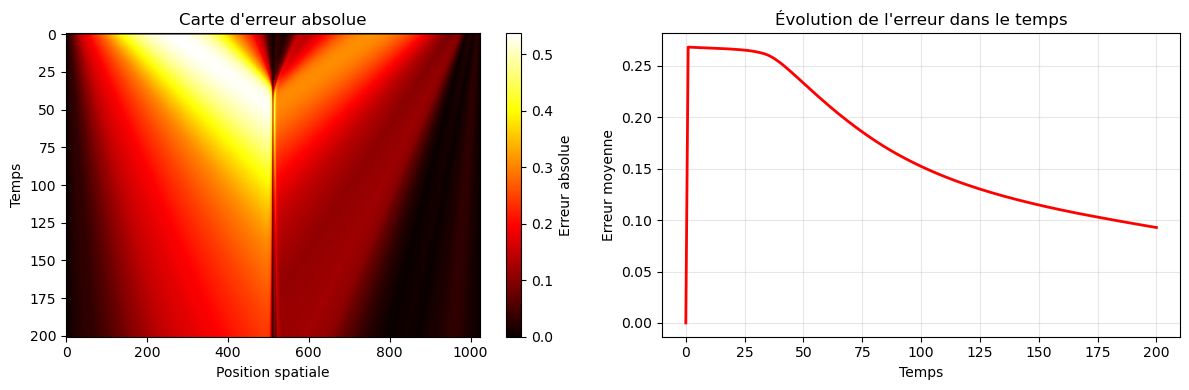

In [ ]:
# Complete evaluation with dedicated function
evaluation_results = evaluate_model_on_sample(
    model, 
    train_loader, 
    device, 
    patch_radius, 
    max_val=1.0, 
    val_range=1.0
)

# Display results with dedicated function
true_traj, pred_traj = display_evaluation_results(evaluation_results, show_plots=True)